<a href="https://colab.research.google.com/github/Clarke-Jools-36/diss-gw/blob/testing/autoencoder_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am going to attempt to set up a simple autoencoder. First I need to create data on which to test and train the autoencoder. I will create gravitational wave sections 1 second long with 1024 samples. 
I will also create artefacts which are not gravitational waves. 

In [224]:
import numpy as np
from matplotlib import pyplot as plt

In [225]:
t = np.linspace(0,1,1024) #create an array of time between 0 and 1 second with 1024 samples
a = np.zeros_like(t) #create an array of zeros to populate with amplitude values

In [226]:
print(len(a))
print(len(a)==len(t)) #idiot check early :)

1024
True


Lets start with an artifact, a sin wave which has amplidue of a bell curve

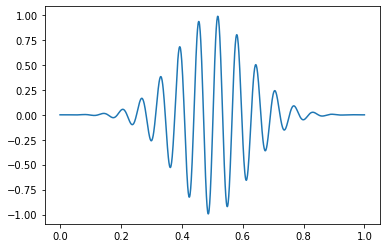

In [227]:
## SIN WAVE ##
A = 0 #amplitude
B = 0.01 #period
C = 0 #phase shift (horizontal)
D = 0 #amplitude shift (vertical)
## BELL CURVE ##
b = 0.03 #width of bell curve describing amplitude
c = 0.5  #phase shift (horizontal) of bell curve

for i,t_ in enumerate(t):
  A = np.e**( -((t_-c)**2 / b) ) #setting amplidude to bell curve
  #plt.plot(t_, A, "x")

  a[i] = A * np.sin( (1/B) * (t_ - C) ) + D

plt.plot(t,a)

We can also make the frequency of the sin wave lower at the tail ends. 

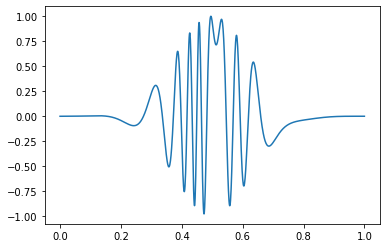

In [228]:
for i,t_ in enumerate(t):
  A = np.e**( -((t_-c)**2 / b) ) #setting amplidude to bell curve
  
  B = -0.035 * (np.e**( -((t_-c)**2 / b) )) + 0.05 #setting freq to bell curve
  #plt.plot(t_, B, "x")
  a[i] = A * np.sin( (1/B) * (t_ - C) ) + D

plt.plot(t,a)

Something funky is happening here, potentially because of the syncing with the sample rate?

Lets move on to grav wave like signals. These are less symettrical



In [229]:
t = np.linspace(0,1,1024) #create an array of time between 0 and 1 second with 1024 samples
a = np.zeros_like(t) #create an array of zeros to populate with amplitude values

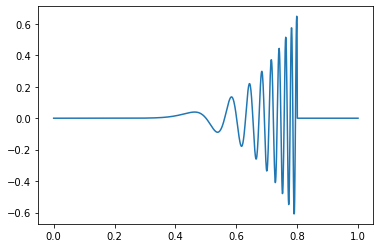

In [230]:
## SIN WAVE ##
A = 0 #amplitude
B = 0.01 #period
C = 0 #phase shift (horizontal)
D = 0 #amplitude shift (vertical)
## POLYNOMIAL ##
b = 2 #amplitude of amplitude polynomial
c = 0.005 #amplitude of freq polynomial
d = 5 #degree of polynomial
for i,t_ in enumerate(t):
  if 0<t_<0.8:
    A = 2*t_**5 # amplitude increases with polynomial 5
    B = 0.005/t_**5 #freq increases
  else:
    A = 0

  a[i] = A * np.sin( (1/B) * (t_ - C) ) + D

plt.plot(t,a)

Lets make some functions, and save this data

In [231]:
def blip(seed = None):
  if seed == None:
    seed = np.random.randint(0,999999)
  np.random.seed(seed)


  t = np.linspace(0,1,1024) #create an array of time between 0 and 1 second with 1024 samples
  a = np.zeros_like(t) #create an array of zeros to populate with amplitude values
  A,B,C,D,b,c = 0,0.01,((np.random.rand()-0.5)),0,0.03 + (0.05*(np.random.rand()-0.5)),0.5 + (0.5*(np.random.rand()-0.5))

  randomA = (0.5*(np.random.rand()-0.5)) #maximum amplitude

  for i,t_ in enumerate(t):
    A = randomA * np.e**( -((t_-c)**2 / b) ) #setting amplidude to bell curve
    a[i] = A * np.sin( (1/B) * (t_ - C) ) + D

  return {"data":{"time":t,"amplitude":a},"seed":seed}


In [232]:
def wave(seed = None):
  if seed == None:
    seed = np.random.randint(0,999999)
  np.random.seed(seed)


  t = np.linspace(0,1,1024) #create an array of time between 0 and 1 second with 1024 samples
  a = np.zeros_like(t) #create an array of zeros to populate with amplitude values

  A,B,C,D,b,c,d = 0,0.01,((np.random.rand()-0.5)),0,2 + ((np.random.rand()-0.5)),0.005 + (0.001*(np.random.rand()-0.5)),5

  randomA = (0.5*(np.random.rand()-0.5)) #maximum amplitude

  for i,t_ in enumerate(t):
    if 0<t_<0.75+C/2:
      A = randomA * 2*t_**5 # amplitude increases with polynomial 5
      B = 0.005/t_**5 #freq increases
    else:
      A = 0

    a[i] = A * np.sin( (1/B) * (t_ - C) ) + D

  return {"data":{"time":t,"amplitude":a},"seed":seed}



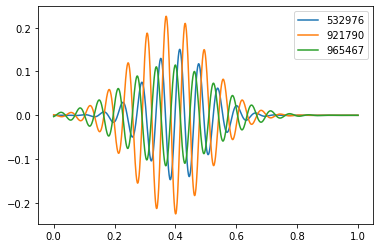

In [233]:
blip_ = blip()
plt.plot(blip_["data"]["time"],blip_["data"]["amplitude"], label = blip_["seed"])
blip_ = blip()
plt.plot(blip_["data"]["time"],blip_["data"]["amplitude"], label = blip_["seed"])
blip_ = blip()
plt.plot(blip_["data"]["time"],blip_["data"]["amplitude"], label = blip_["seed"])

plt.legend()

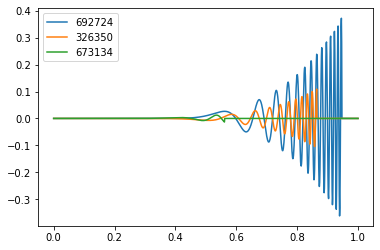

In [234]:
wave_ = wave()
plt.plot(wave_["data"]["time"],wave_["data"]["amplitude"], label = wave_["seed"])
wave_ = wave()
plt.plot(wave_["data"]["time"],wave_["data"]["amplitude"], label = wave_["seed"])
wave_ = wave()
plt.plot(wave_["data"]["time"],wave_["data"]["amplitude"], label = wave_["seed"])


plt.legend()

lets generate some data

In [240]:
x_train = np.zeros([38000,1024])
x_test = np.zeros([8000,1024])

print(f"generating train data, expect {len(x_train)} vals")
for i, _ in tqdm(enumerate(x_train), total = len(x_train)):
  x_train[i] = blip()["data"]["amplitude"]

print(f"generating test data, expect {len(x_test)} vals")
for i, _ in tqdm(enumerate(x_test), total = len(x_test)):
  x_test[i] = blip()["data"]["amplitude"]

generating train data, expect 38000 vals


  0%|          | 0/38000 [00:00<?, ?it/s]

generating test data, expect 8000 vals


  0%|          | 0/8000 [00:00<?, ?it/s]

Time to start thinking about the autoencoder

In [272]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(1024,)) 
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(1024, activation='sigmoid')(encoded)  
# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Now we create an encoder model

In [264]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

and a decoder model

In [265]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [266]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [267]:
from tqdm.notebook import tqdm #this puts loading bars onto for loops 

In [268]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
print(x_test.shape)

(38000, 1024)
(8000, 1024)


now lets train for 50 epochs

In [269]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
149/149 [==============================] - 2s 13ms/step - loss: 0.4995 - val_loss: 0.2083
Epoch 2/50
149/149 [==============================] - 2s 13ms/step - loss: 0.0909 - val_loss: 0.0357
Epoch 3/50
149/149 [==============================] - 3s 19ms/step - loss: 0.0220 - val_loss: 0.0134
Epoch 4/50
149/149 [==============================] - 2s 14ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 5/50
149/149 [==============================] - 2s 15ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 6/50
149/149 [==============================] - 2s 12ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 7/50
149/149 [==============================] - 2s 12ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 8/50
149/149 [==============================] - 2s 11ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/50
149/149 [==============================] - 2s 12ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/50
149/149 [==============================] - 2s 14ms/step - loss: 0.0011 - val_lo

lets visualise

In [270]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

250/250 [==============================] - 0s 1ms/step


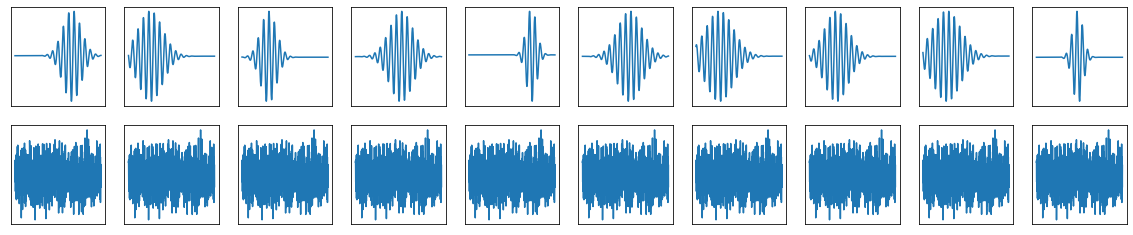

In [271]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.plot(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()